# Далее будут реализованы запросы на выборку для таблицы, в которой представлена информация о командировках сотрудников некоторой организации:

Вывести информацию о командировках тех сотрудников, фамилия которых заканчивается на букву «а».
* Вывести в алфавитном порядке фамилии, имена и отчества тех сотрудников, которые были в командировке в Москве.
* Для каждого города посчитать, сколько раз сотрудники в нем были.
* Вывести два города, в которых чаще всего были в командировках сотрудники.
* Вывести информацию о длительности командировок сотрудников.
* Вывести информацию о командировках сотрудника(ов), которые были самыми короткими по времени.
* Вывести информацию о командировках, начало и конец которых относятся к одному месяцу.
* Вывести номер месяца и количество командировок, первый день которых приходился на этот месяц.
* Вывести сумму суточных  для командировок сотрудников.
* Вывести фамилию с инициалами и общую сумму суточных, полученных за все командировки для тех сотрудников, которые были в командировках больше чем 3 раза.

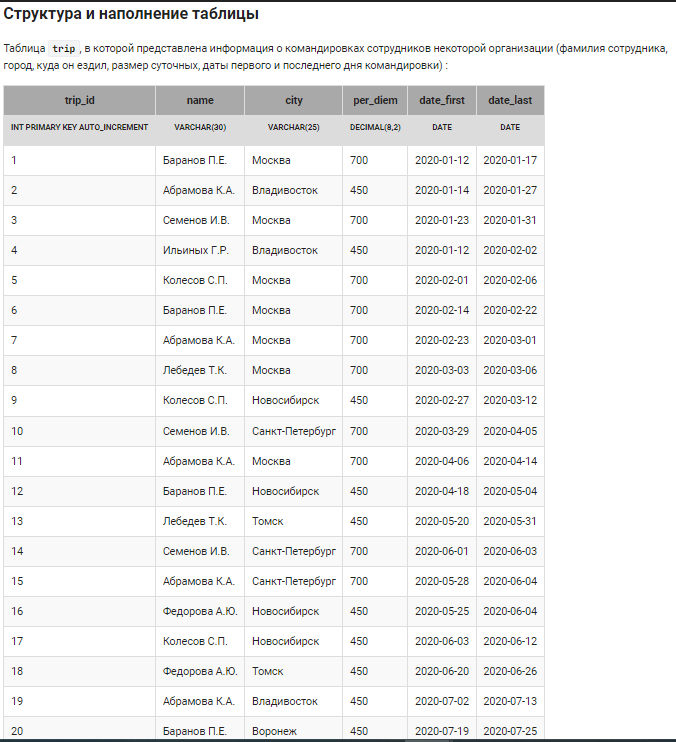

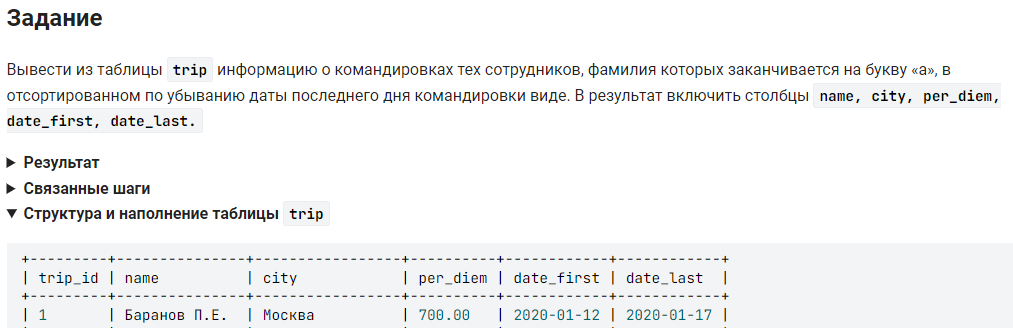

~~~~mySQL
SELECT name,
       city,
       per_diem,
       date_first,
       date_last
  FROM trip
 WHERE name LIKE '%а %'
 ORDER BY date_last DESC;
~~~~

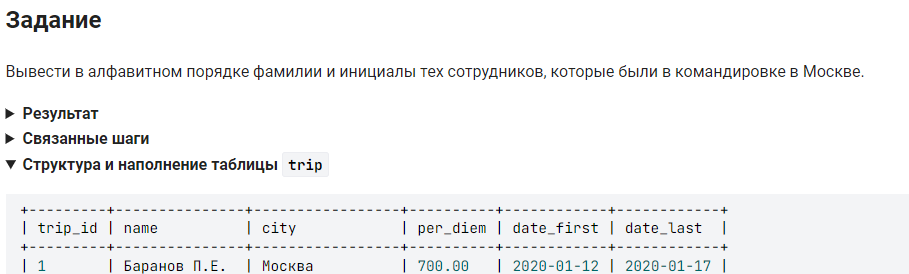

~~~~mySQL
SELECT DISTINCT(name)
  FROM trip
 WHERE city = 'Москва'
 ORDER BY name;
~~~~

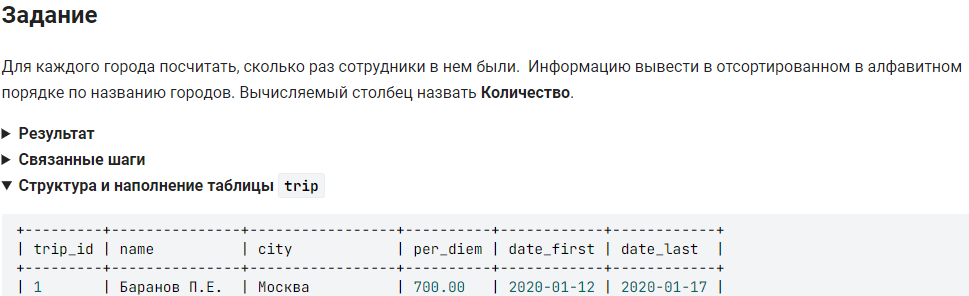

~~~~mySQL
SELECT city,
       COUNT(*) AS Количество
  FROM trip
 GROUP BY city
 ORDER BY city;
~~~~

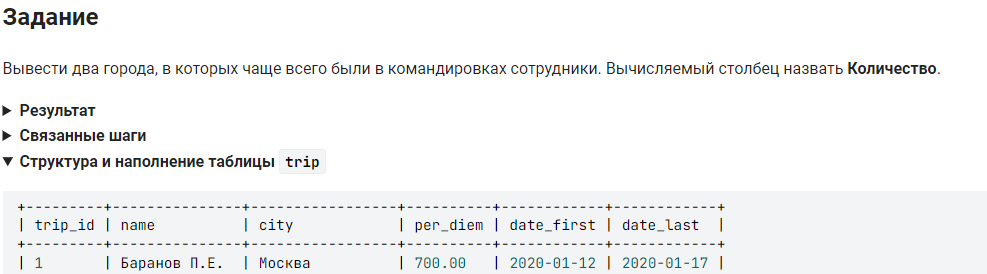

~~~~mySQL
SELECT city,
       COUNT(*) AS Количество
  FROM trip
 GROUP BY city
 ORDER BY Количество DESC
 LIMIT 2;
~~~~

## Задание
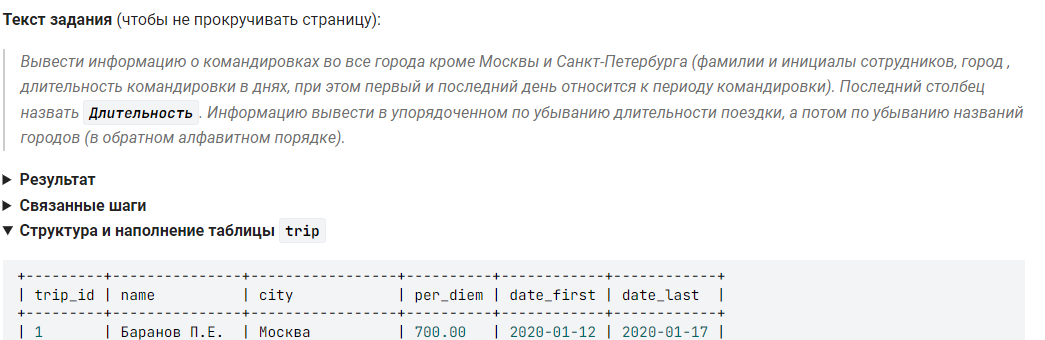

~~~~mySQL
SELECT name,
       city,
       DATEDIFF(date_last, date_first) + 1 AS Длительность
  FROM trip
 WHERE city not in ('Москва', 'Санкт-Петербург')
 ORDER BY Длительность DESC, city DESC;
~~~~

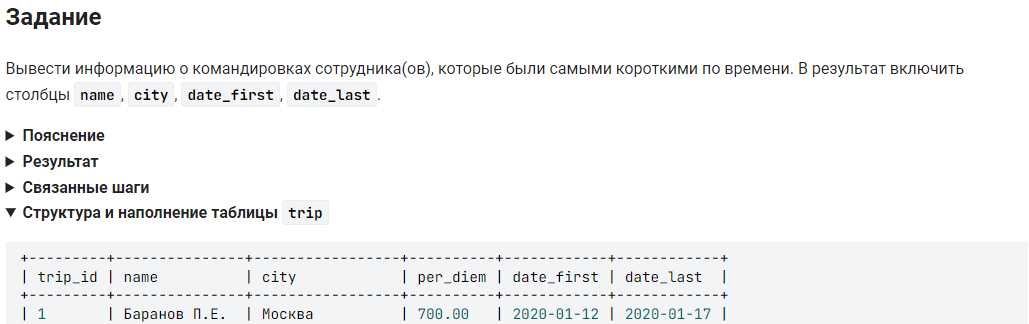

~~~~mySQL
SELECT name,
       city, 
       date_first, 
       date_last
  FROM trip
 WHERE DATEDIFF(date_last, date_first) = (SELECT MIN(DATEDIFF(date_last, date_first))
                                            FROM trip);
~~~~

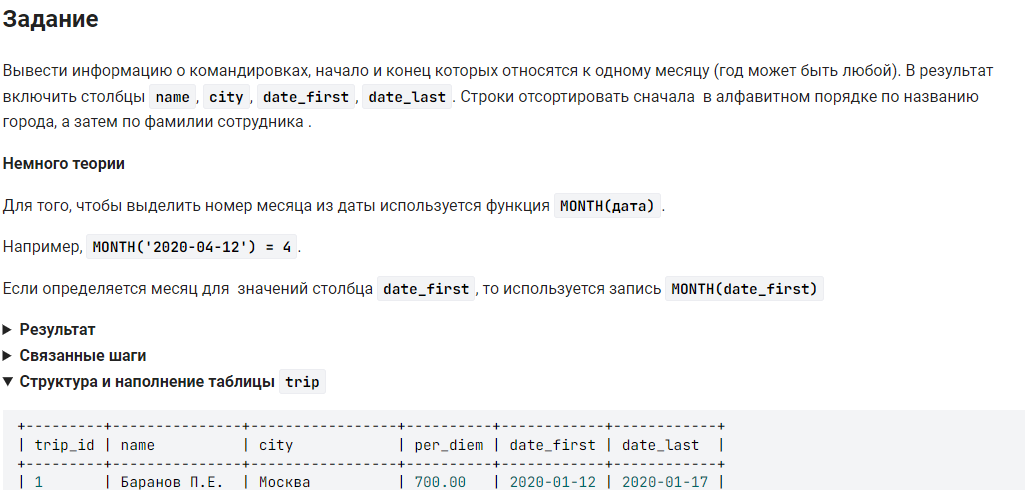

~~~~mySQL
SELECT name, 
       city, 
       date_first,
       date_last
  FROM trip
 WHERE MONTH(date_first) = MONTH(date_last)
 ORDER BY city, name;
~~~~

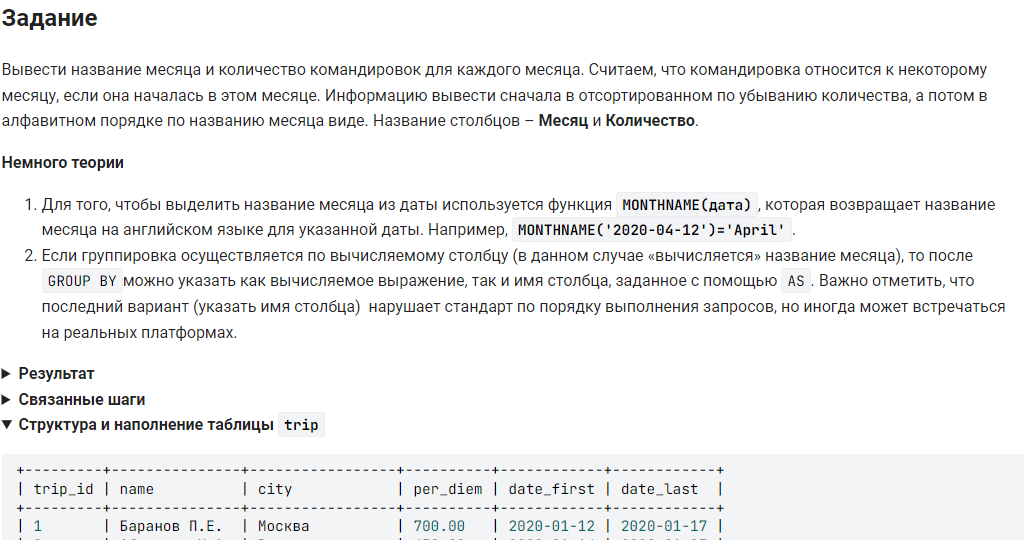

~~~~mySQL
SELECT MONTHNAME(date_first) AS Месяц,
       COUNT(*) AS Количество
  FROM trip
 GROUP BY MONTHNAME(date_first)
 ORDER BY Количество DESC, Месяц;
~~~~

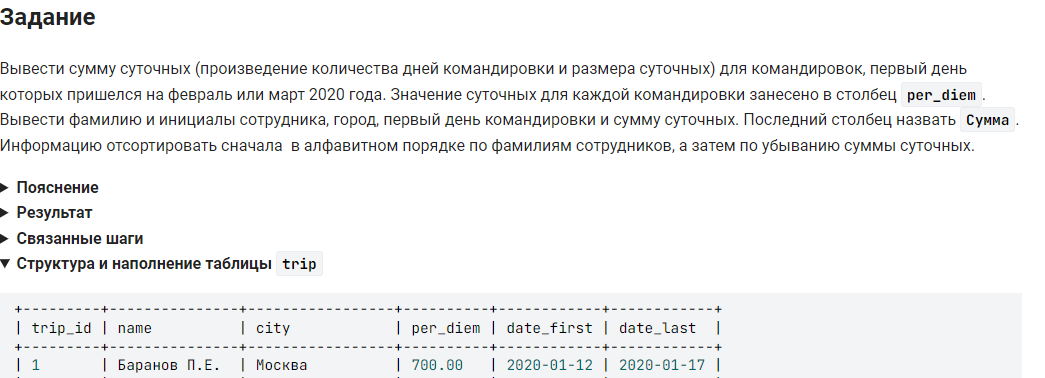

~~~~mySQL
SELECT name,
       city,
       date_first,
       (DATEDIFF(date_last, date_first) + 1) * per_diem AS Сумма
  FROM trip
 WHERE YEAR(date_first) = 2020 
   AND MONTH(date_first) IN (2, 3)
 ORDER BY name, Сумма DESC;
~~~~

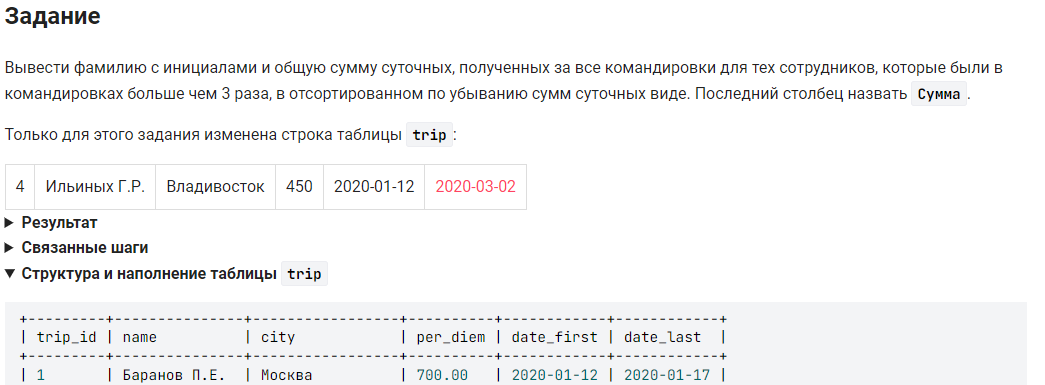

~~~~mySQL
SELECT name,
       SUM((DATEDIFF(date_last, date_first) + 1) * per_diem) AS Сумма
  FROM trip
 GROUP BY name
HAVING COUNT(*) > 3
 ORDER BY Сумма DESC;
~~~~

# Далее будут реализованы запросы на выборку для таблицы, в которой представлена информация о начисленных водителям штрафах за нарушения правил дорожного движения (ПДД). 

С помощью запросов корректировки необходимо выполнить следующие действия:  
* создать таблицу с информацией о штрафах ;
* заполнить ее;
* занести сумму штрафа за каждое новое нарушение ПДД;
* если водитель на определенной машине совершил повторное нарушение, то сумму его штрафа за данное нарушение нужно увеличить в два раза (часть 1, часть 2) ;
* если водитель оплатил свой штраф в течение 20 дней со дня нарушения, то значение его штрафа уменьшить в два раза;
* создать новую таблицу,  в которую включить информацию о всех неоплаченных штрафах;
* удалить  информацию о нарушениях, совершенных раньше некоторой даты.

На четвертом шаге рассматривается временное именование таблиц (алиасы). 

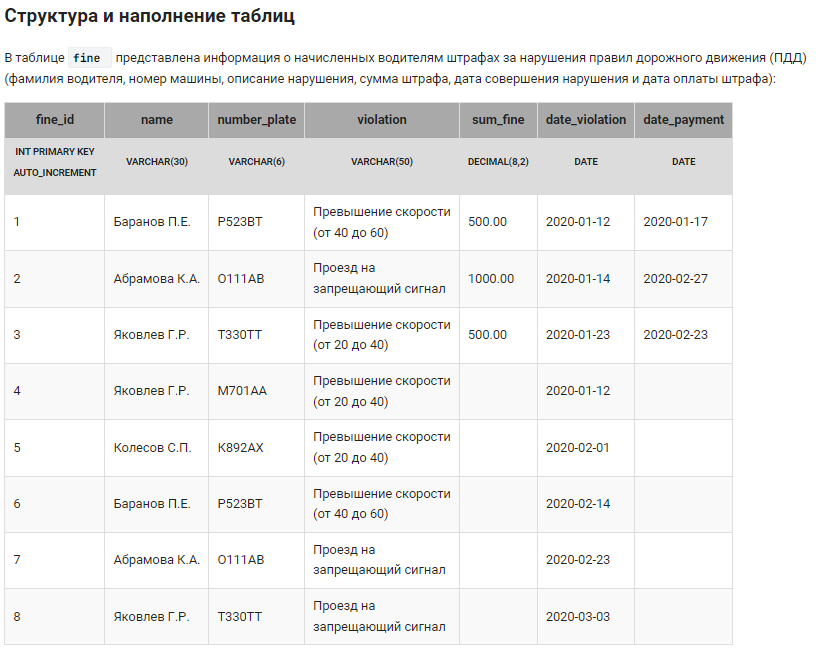

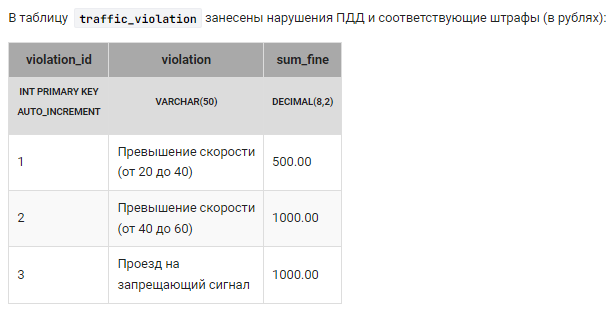

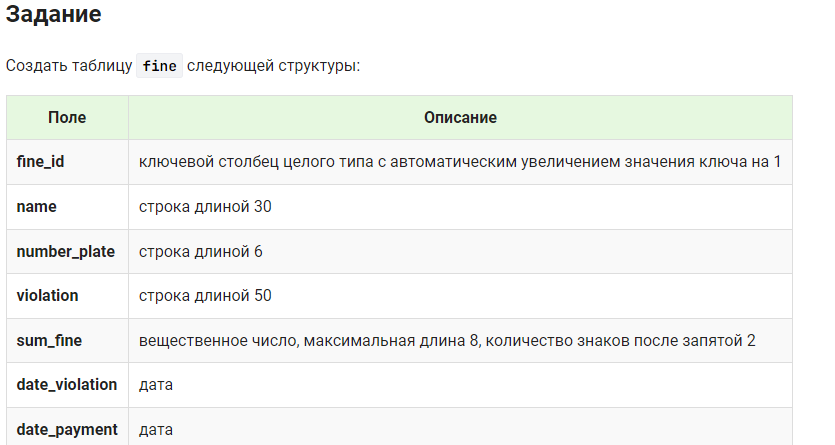

~~~~mySQL
CREATE TABLE fine(
    fine_id INT PRIMARY KEY AUTO_INCREMENT,
    name VARCHAR(30),
    number_plate VARCHAR(6),
    violation VARCHAR(50),
    sum_fine DECIMAL(8, 2),
    date_violation DATE,
    date_payment DATE);
~~~~

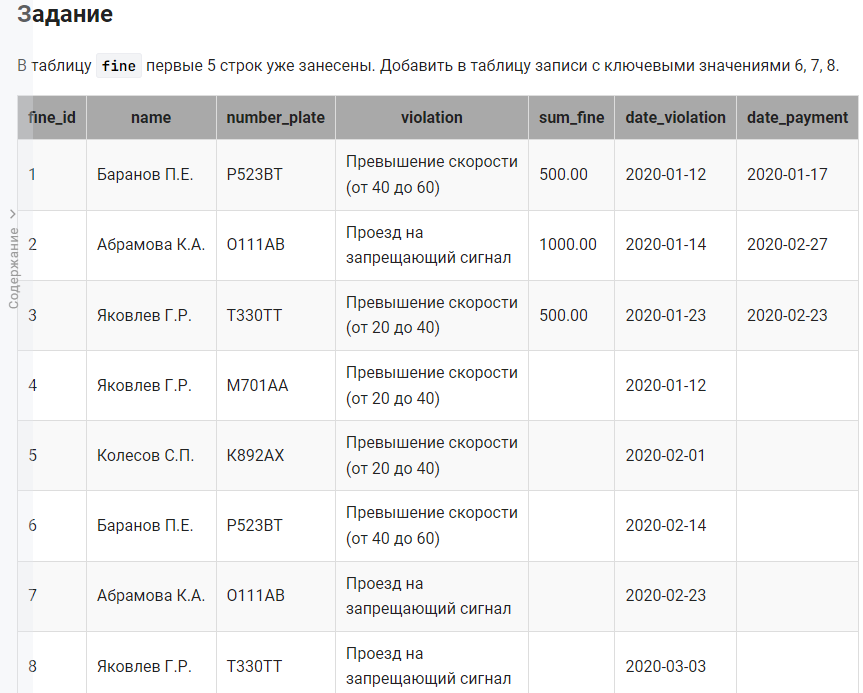

~~~~mySQL
INSERT INTO fine(name, number_plate, violation, date_violation)
VALUES ('Баранов П.Е.', 'Р523ВТ', 'Превышение скорости(от 40 до 60)', '2020-02-14'),
       ('Абрамова К.А.', 'О111АВ', 'Проезд на запрещающий сигнал', '2020-02-23'),
       ('Яковлев Г.Р.', 'Т330ТТ', 'Проезд на запрещающий сигнал', '2020-03-03');
~~~~

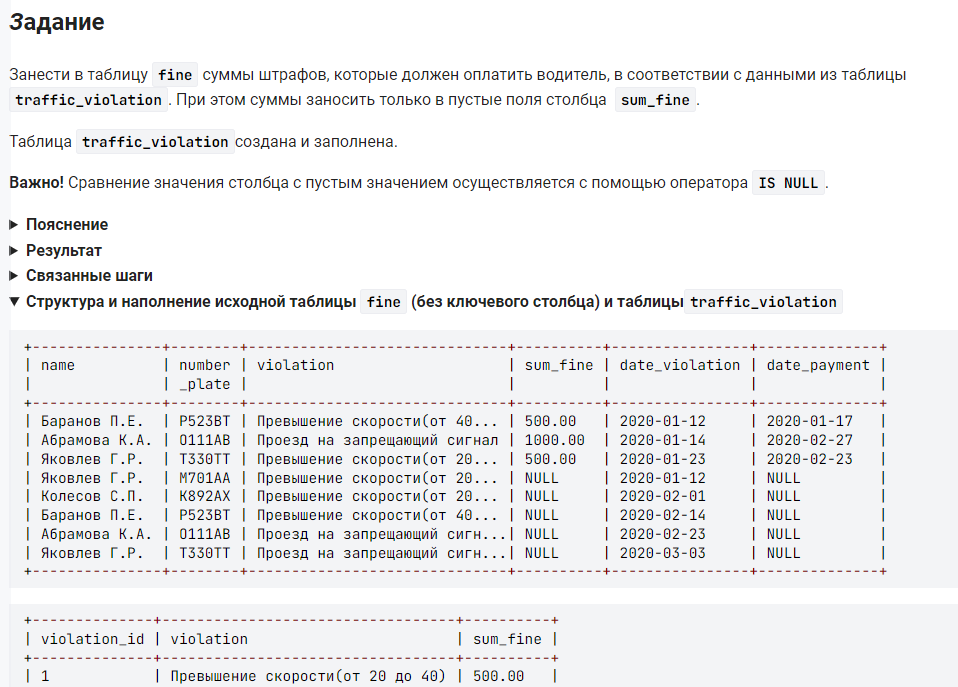

~~~~mySQL
UPDATE fine SET
       sum_fine = (SELECT tv.sum_fine
                      FROM traffic_violation AS tv
                     WHERE tv.violation = fine.violation)
 WHERE sum_fine IS NULL;
~~~~

## Способ 2, без использования подзапроса.
~~~~mySQL
UPDATE fine as f,
       traffic_violation AS tv
   SET
       f.sum_fine = tv.sum_fine
 WHERE f.sum_fine IS NULL 
   AND f.violation = tv.violation;
~~~~

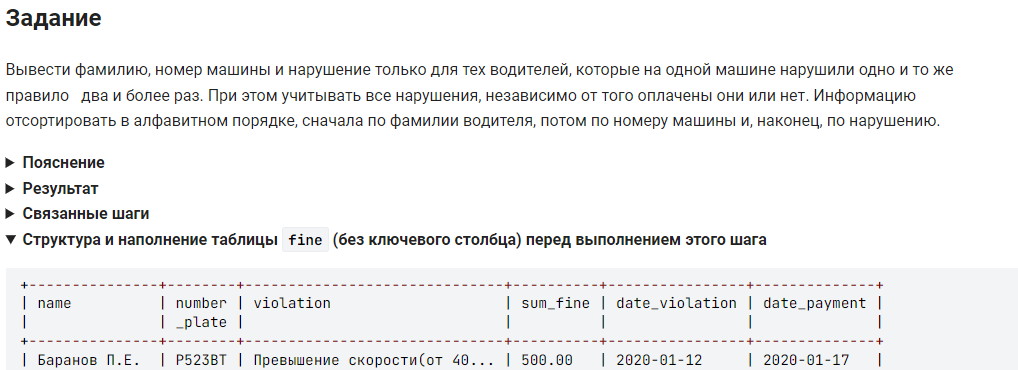

~~~~mySQL
SELECT name,
       number_plate,
       violation
  FROM fine
 GROUP BY name,
          number_plate,
          violation
HAVING COUNT(*) >= 2
ORDER BY name,
         number_plate,
         violation;
~~~~

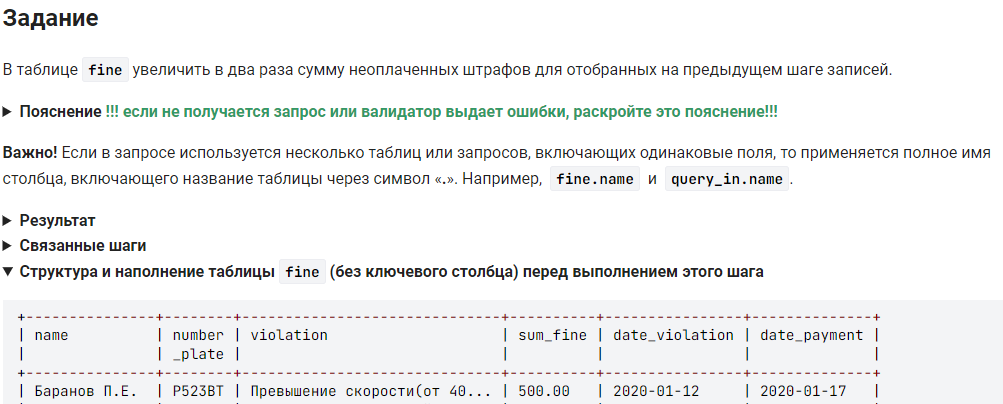

~~~~mySQL
UPDATE fine AS f,
      (SELECT name,
              number_plate,
              violation
         FROM fine
        GROUP BY name,
                 number_plate,
                 violation
       HAVING COUNT(date_payment IS NULL) >= 2) AS query_in
   SET 
       f.sum_fine = f.sum_fine * 2
 WHERE f.date_payment IS NULL
   AND f.name = query_in.name
   AND f.number_plate = query_in.number_plate
   AND f.violation = query_in.violation;
~~~~

## Чуть исправлено условие, для удобства и краткости.
~~~~mySQL
UPDATE fine AS f,
      (SELECT name,
              number_plate,
              violation
         FROM fine
        GROUP BY name,
                 number_plate,
                 violation
       HAVING COUNT(date_payment IS NULL) >= 2) AS query_in
   SET 
       f.sum_fine = f.sum_fine * 2
 WHERE f.date_payment IS NULL
   AND (f.name, f.number_plate, f.violation) = 
       (query_in.name, query_in.number_plate, query_in.violation);
~~~~

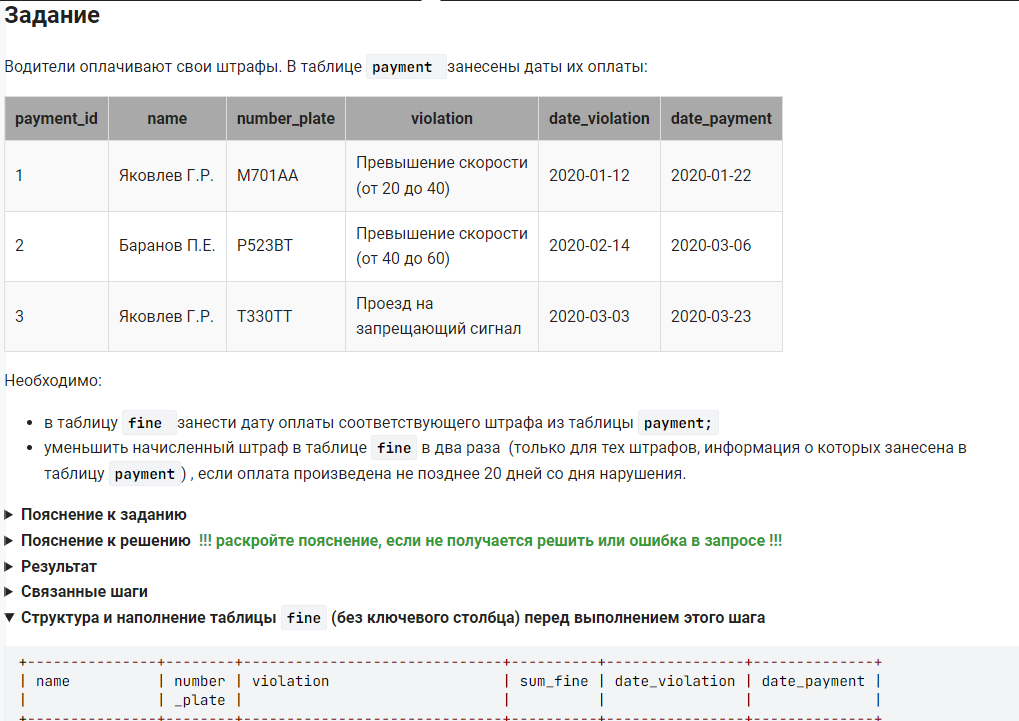

~~~~mySQL
UPDATE fine AS f,
       payment AS p
   SET
       f.date_payment = p.date_payment,
       f.sum_fine = if(DATEDIFF(p.date_payment, f.date_violation) <= 20, f.sum_fine / 2, f.sum_fine)
 WHERE f.name = p.name
   AND f.number_plate = p.number_plate
   AND f.violation = p.violation
   AND f.date_violation = p.date_violation;
~~~~

## Чуть исправлено условие, для удобства и краткости 
~~~~mySQL
UPDATE fine AS f,
       payment AS p
   SET
       f.date_payment = p.date_payment,
       f.sum_fine = if(DATEDIFF(p.date_payment, f.date_violation) <= 20, f.sum_fine / 2, f.sum_fine)
 WHERE (f.name, f.number_plate, f.violation, f.date_violation) =
       (p.name, p.number_plate, p.violation, p.date_violation);
~~~~

## В тестах условие "f.date_payment IS NULL" не проверяется, но оно поможет пересчитывать / изменять только не оплаченные ранее штрафы.
~~~~mySQL
UPDATE fine AS f,
       payment AS p
   SET
       f.date_payment = p.date_payment,
       f.sum_fine = if(DATEDIFF(p.date_payment, f.date_violation) <= 20, f.sum_fine / 2, f.sum_fine)
 WHERE f.date_payment IS NULL
   AND (f.name, f.number_plate, f.violation, f.date_violation) =
       (p.name, p.number_plate, p.violation, p.date_violation);
~~~~

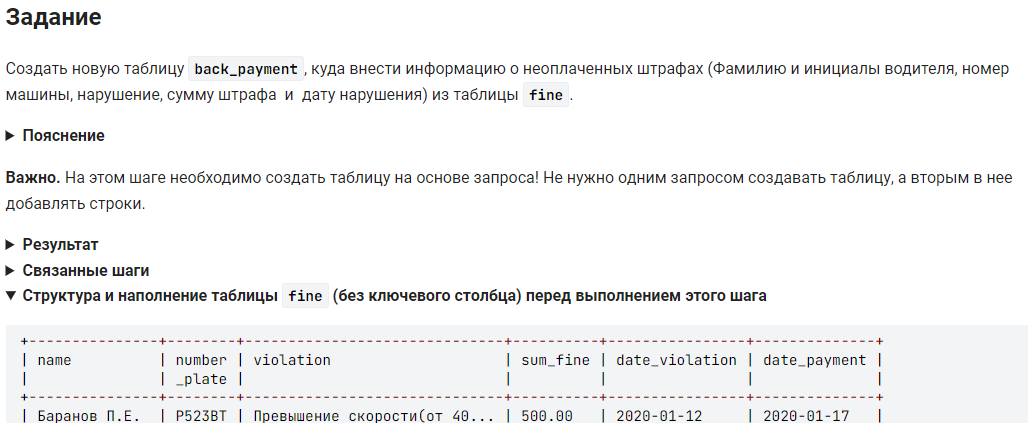

~~~~mySQL
CREATE TABLE back_payment (SELECT name,
                                  number_plate,
                                  violation,
                                  sum_fine,
                                  date_violation
                             FROM fine
                            WHERE date_payment IS NULL);
~~~~

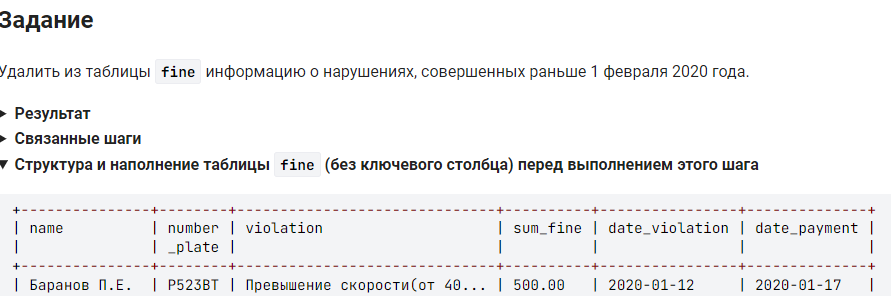

~~~~mySQL
DELETE FROM fine
      WHERE date_violation < '2020-02-01';
~~~~